# MLP
MLP, K=5, droput, 150 epoch.

lncRNA. Baseline, nothing exluded.

Like MLP_260 but use class weights.

In [1]:

from datetime import datetime
print(datetime.now())

2023-04-15 16:41:37.427842


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_268'

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-15 16:42:06.668363
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd)  # no validation )
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-15 16:42:07.406940
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4371
Num RCI: 4371
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4371 sequences.

Training # 1 1
2023-04-15 16:42:20.701787
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-15 16:42:20.962223
Discriminator is GMM
Means [-2.7492144436660695, -0.12353649167716341]
Variances [1.99461298 1.50711037]
Priors [0.42947611 0.57052389]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2091:1405 59.81%
Computed class weights: {0: 1.2441281138790035, 1: 0.8359636537541846}
Valid 1:0 508:367 58.06%
FIT
2023-04-15 16:42:22.261992


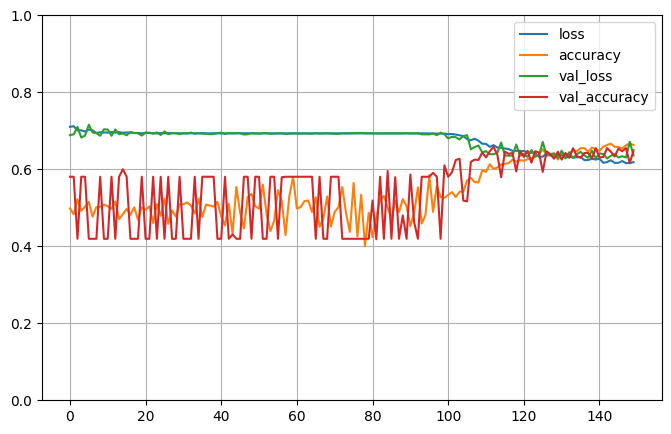


Testing # 1 1
2023-04-15 16:43:45.788161
2023-04-15 16:43:45.788212
PREDICT
2023-04-15 16:43:45.802620
Test 1:0 508:367 58.06%
Predict 1:0 497:378 56.80%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5196506 mean 0.16729672 std
Range of scores: 0.05511394 to 0.87133306
Score threshold 0.5
Confusion matrix
 [[219 148]
 [159 349]]
Normalized matrix
 [[0.25028571 0.16914286]
 [0.18171429 0.39885714]]
Extreme scores correct, pos:neg 168 110
Extreme scores incorrect pos:neg 53 48


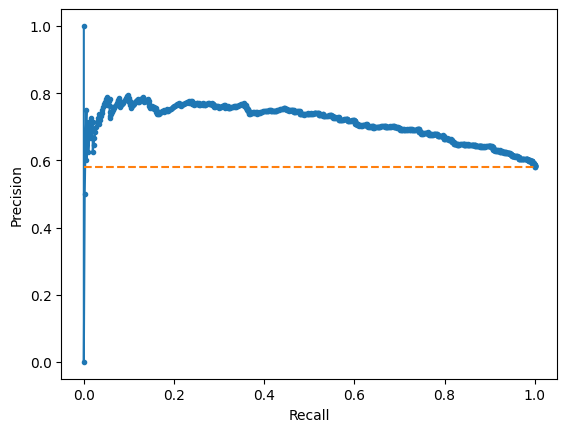

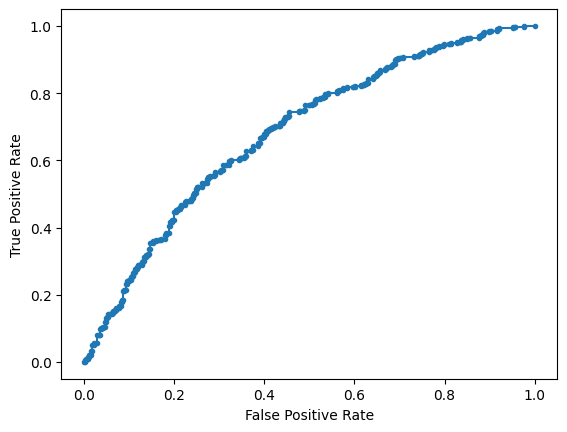

Accuracy: 64.91% Precision: 70.22% Recall: 68.70%
F1: 69.45% MCC: 0.2827
AUPRC: 71.35% AUROC: 68.27%
 accuracy [64.91428571428571]
 precision [70.22132796780684]
 recall [68.7007874015748]
 F1 [69.45273631840797]
 MCC [0.28265617632675105]
 AUPRC [71.34979480451248]
 AUROC [68.26739470917633]

Training # 1 2
2023-04-15 16:43:46.543757
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-15 16:43:46.767317
Discriminator is GMM
Means [-2.755657665223357, -0.15507654504140742]
Variances [2.06354601 1.42953516]
Priors [0.432784 0.567216]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2091:1405 59.81%
Computed class weights: {0: 1.2441281138790035, 1: 0.8359636537541846}
Valid 1:0 516:359 58.97%
FIT
2023-04-15 16:43:47.842217


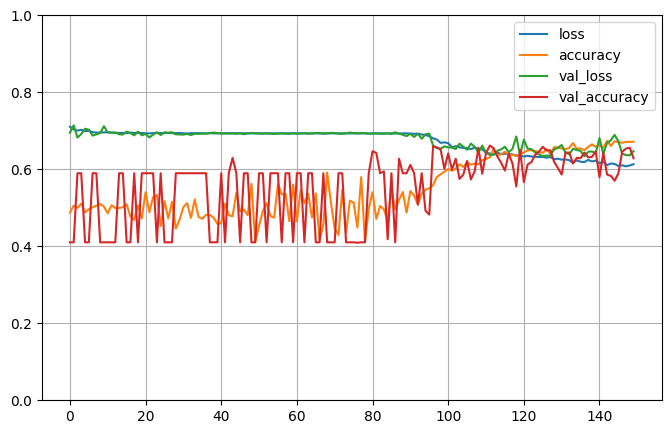


Testing # 1 2
2023-04-15 16:46:11.323657
2023-04-15 16:46:11.323764
PREDICT
2023-04-15 16:46:11.331078
Test 1:0 516:359 58.97%
Predict 1:0 507:368 57.94%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5231972 mean 0.17351682 std
Range of scores: 0.030319735 to 0.9131182
Score threshold 0.5
Confusion matrix
 [[201 158]
 [167 349]]
Normalized matrix
 [[0.22971429 0.18057143]
 [0.19085714 0.39885714]]
Extreme scores correct, pos:neg 166 102
Extreme scores incorrect pos:neg 64 43


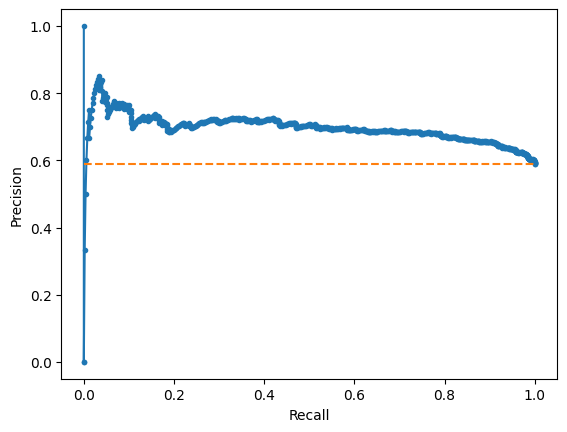

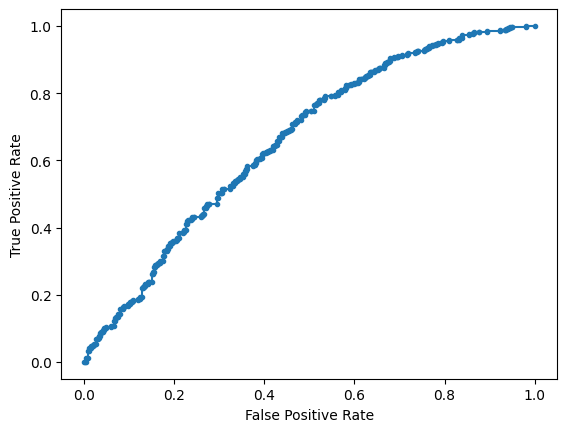

Accuracy: 62.86% Precision: 68.84% Recall: 67.64%
F1: 68.23% MCC: 0.2354
AUPRC: 69.59% AUROC: 65.82%
 accuracy [62.857142857142854]
 precision [68.83629191321499]
 recall [67.63565891472868]
 F1 [68.23069403714564]
 MCC [0.23540035940798]
 AUPRC [69.58839408037693]
 AUROC [65.81643669970416]

Training # 1 3
2023-04-15 16:46:11.910496
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-15 16:46:12.194663
Discriminator is GMM
Means [-0.10647496210854544, -2.781995929410141]
Variances [1.49864906 2.0823436 ]
Priors [0.57174195 0.42825805]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2095:1402 59.91%
Computed class weights: {0: 1.2471469329529243, 1: 0.8346062052505967}
Valid 1:0 510:364 58.35%
FIT
2023-04-15 16:46:13.296904


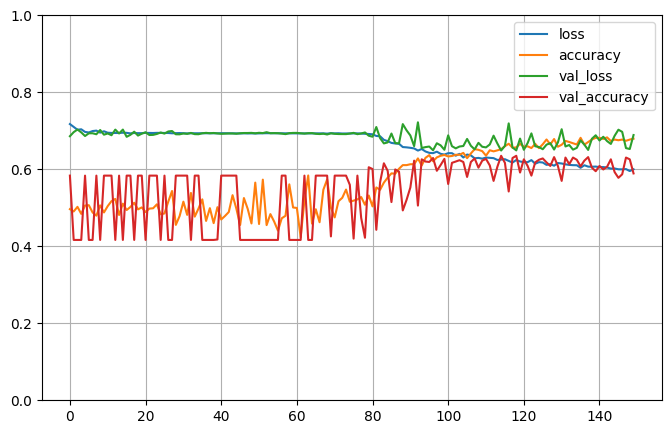


Testing # 1 3
2023-04-15 16:47:36.502667
2023-04-15 16:47:36.502713
PREDICT
2023-04-15 16:47:36.514411
Test 1:0 510:364 58.35%
Predict 1:0 409:465 46.80%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.47416124 mean 0.1888066 std
Range of scores: 0.027045347 to 0.87170357
Score threshold 0.5
Confusion matrix
 [[235 129]
 [230 280]]
Normalized matrix
 [[0.26887872 0.14759725]
 [0.26315789 0.32036613]]
Extreme scores correct, pos:neg 124 141
Extreme scores incorrect pos:neg 48 105


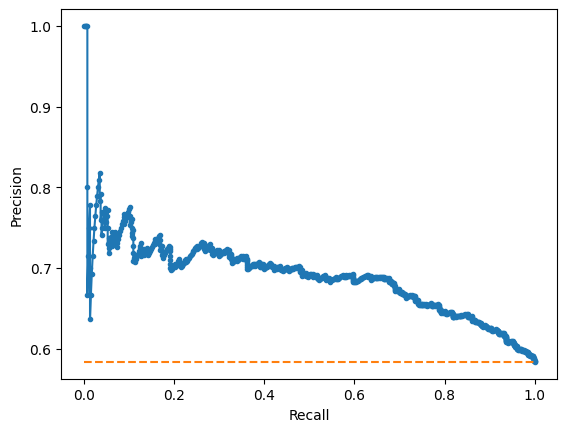

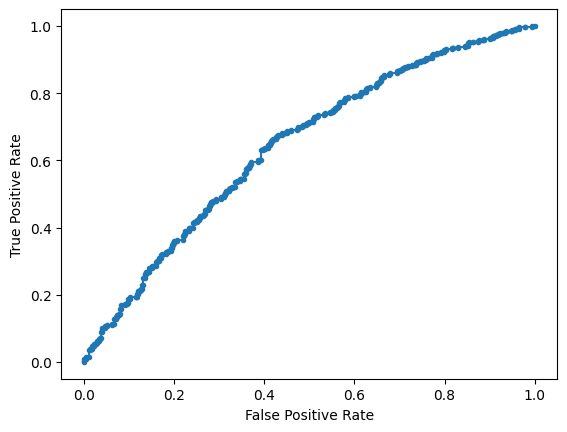

Accuracy: 58.92% Precision: 68.46% Recall: 54.90%
F1: 60.94% MCC: 0.1923
AUPRC: 68.94% AUROC: 64.29%
 accuracy [58.924485125858126]
 precision [68.45965770171149]
 recall [54.90196078431373]
 F1 [60.93579978237214]
 MCC [0.1922843999177123]
 AUPRC [68.94265053887732]
 AUROC [64.29002370178841]

Training # 1 4
2023-04-15 16:47:37.096321
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-15 16:47:37.373165
Discriminator is GMM
Means [-0.10819901877560015, -2.7618271525964446]
Variances [1.47141094 1.96087741]
Priors [0.5591907 0.4408093]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2025:1472 57.91%
Computed class weights: {0: 1.1878396739130435, 1: 0.8634567901234568}
Valid 1:0 532:342 60.87%
FIT
2023-04-15 16:47:38.522766


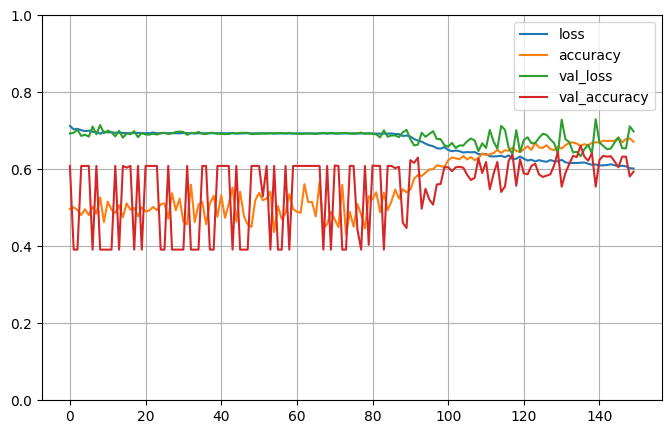


Testing # 1 4
2023-04-15 16:49:03.740393
2023-04-15 16:49:03.740440
PREDICT
2023-04-15 16:49:03.745507
Test 1:0 532:342 60.87%
Predict 1:0 385:489 44.05%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.45461553 mean 0.19701952 std
Range of scores: 0.0066352077 to 0.83561623
Score threshold 0.5
Confusion matrix
 [[238 104]
 [251 281]]
Normalized matrix
 [[0.27231121 0.11899314]
 [0.28718535 0.3215103 ]]
Extreme scores correct, pos:neg 126 155
Extreme scores incorrect pos:neg 40 118


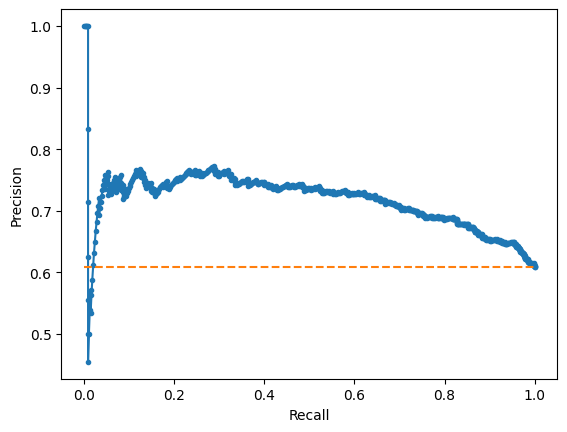

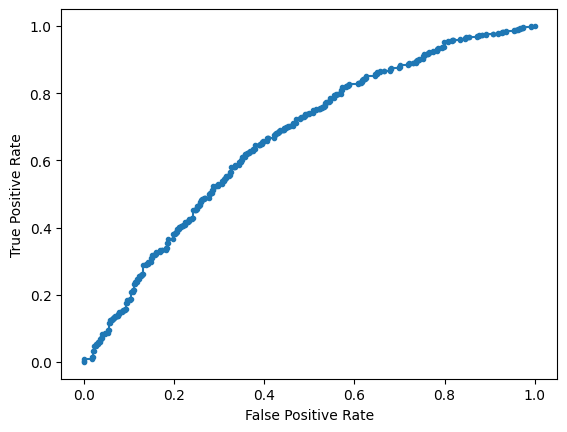

Accuracy: 59.38% Precision: 72.99% Recall: 52.82%
F1: 61.29% MCC: 0.2203
AUPRC: 71.84% AUROC: 66.38%
 accuracy [59.382151029748286]
 precision [72.98701298701299]
 recall [52.819548872180455]
 F1 [61.28680479825519]
 MCC [0.22030768914336202]
 AUPRC [71.84145679483136]
 AUROC [66.38306292045904]

Training # 1 5
2023-04-15 16:49:04.357316
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-15 16:49:04.577701
Discriminator is GMM
Means [-0.16130573241105356, -2.803926567717419]
Variances [1.51780467 2.06827944]
Priors [0.57216584 0.42783416]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2095:1403 59.89%
Computed class weights: {0: 1.2466143977191733, 1: 0.8348448687350836}
Valid 1:0 540:333 61.86%
FIT
2023-04-15 16:49:05.703876


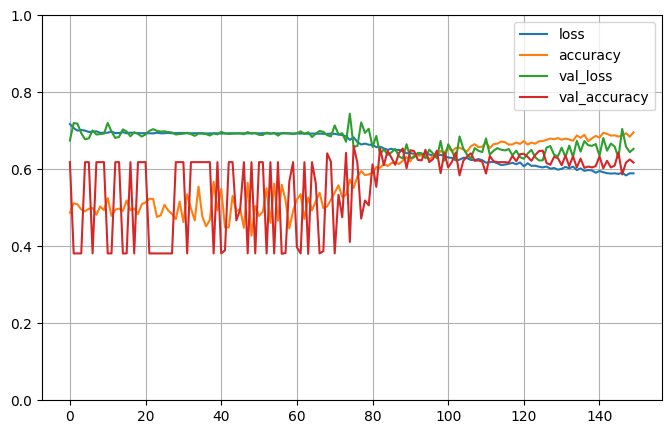


Testing # 1 5
2023-04-15 16:51:28.939076
2023-04-15 16:51:28.939480
PREDICT
2023-04-15 16:51:28.945372
Test 1:0 540:333 61.86%
Predict 1:0 508:365 58.19%
Test sizes (873, 1025) (873,)
Distrib of scores: 0.5334793 mean 0.200309 std
Range of scores: 0.021002306 to 0.9127941
Score threshold 0.5
Confusion matrix
 [[182 151]
 [183 357]]
Normalized matrix
 [[0.20847652 0.17296678]
 [0.20962199 0.40893471]]
Extreme scores correct, pos:neg 217 100
Extreme scores incorrect pos:neg 66 71


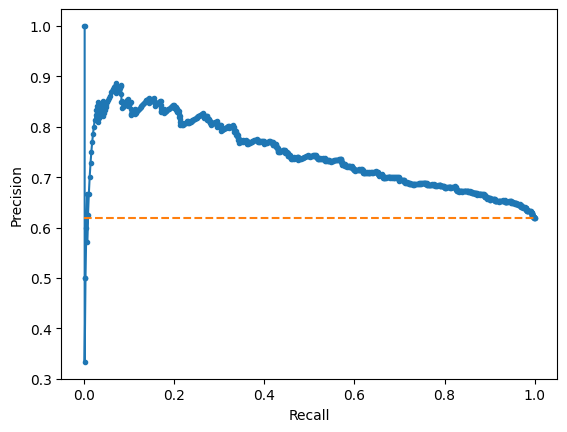

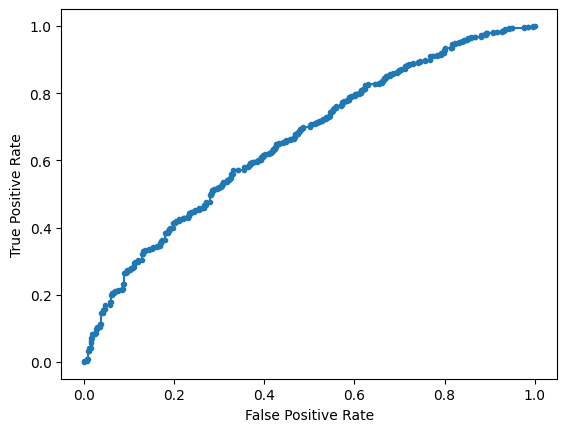

Accuracy: 61.74% Precision: 70.28% Recall: 66.11%
F1: 68.13% MCC: 0.2045
AUPRC: 74.45% AUROC: 65.97%
 accuracy [61.741122565864835]
 precision [70.2755905511811]
 recall [66.11111111111111]
 F1 [68.12977099236642]
 MCC [0.2044978089616207]
 AUPRC [74.44635570807161]
 AUROC [65.97263930597263]

Training # 2 1
2023-04-15 16:51:29.580281
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-15 16:51:29.802466
Discriminator is GMM
Means [-0.11372879952619407, -2.7425220412195874]
Variances [1.4819813 2.0539251]
Priors [0.56613822 0.43386178]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2086:1410 59.67%
Computed class weights: {0: 1.2397163120567376, 1: 0.837967401725791}
Valid 1:0 503:372 57.49%
FIT
2023-04-15 16:51:30.937509


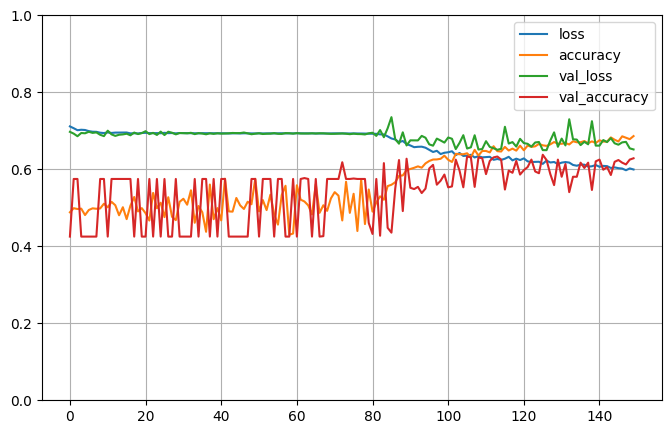


Testing # 2 1
2023-04-15 16:52:56.451517
2023-04-15 16:52:56.451558
PREDICT
2023-04-15 16:52:56.456607
Test 1:0 503:372 57.49%
Predict 1:0 614:261 70.17%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.57302356 mean 0.17180273 std
Range of scores: 0.005663532 to 0.8753307
Score threshold 0.5
Confusion matrix
 [[154 218]
 [107 396]]
Normalized matrix
 [[0.176      0.24914286]
 [0.12228571 0.45257143]]
Extreme scores correct, pos:neg 221 69
Extreme scores incorrect pos:neg 104 27


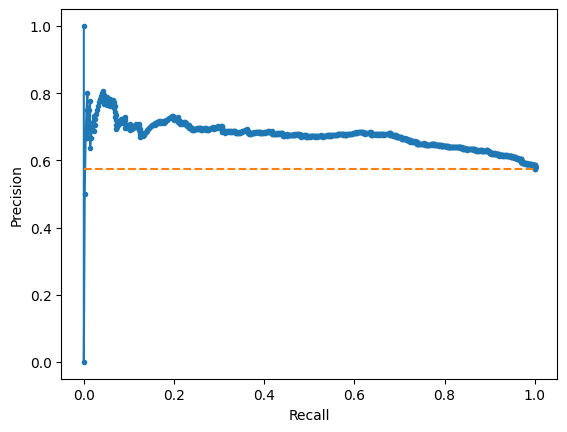

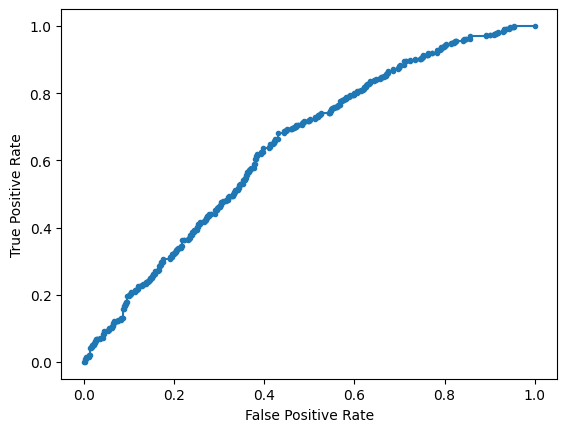

Accuracy: 62.86% Precision: 64.50% Recall: 78.73%
F1: 70.90% MCC: 0.2175
AUPRC: 67.42% AUROC: 64.24%
 accuracy [62.857142857142854]
 precision [64.49511400651465]
 recall [78.72763419483101]
 F1 [70.90420769919427]
 MCC [0.21746899597295888]
 AUPRC [67.41837892279287]
 AUROC [64.2403642660168]

Training # 2 2
2023-04-15 16:52:57.053043
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-15 16:52:57.244686
Discriminator is GMM
Means [-0.1612045132096951, -2.7972537444984797]
Variances [1.47777454 2.02272272]
Priors [0.57568236 0.42431764]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2109:1387 60.33%
Computed class weights: {0: 1.2602739726027397, 1: 0.8288288288288288}
Valid 1:0 526:349 60.11%
FIT
2023-04-15 16:52:58.340330


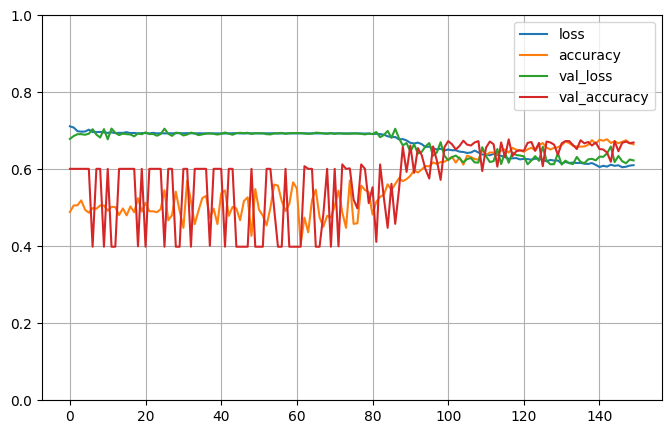


Testing # 2 2
2023-04-15 16:55:21.582272
2023-04-15 16:55:21.582317
PREDICT
2023-04-15 16:55:21.587445
Test 1:0 526:349 60.11%
Predict 1:0 547:328 62.51%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5464609 mean 0.17694014 std
Range of scores: 0.032202367 to 0.8840322
Score threshold 0.5
Confusion matrix
 [[194 155]
 [134 392]]
Normalized matrix
 [[0.22171429 0.17714286]
 [0.15314286 0.448     ]]
Extreme scores correct, pos:neg 208 91
Extreme scores incorrect pos:neg 72 40


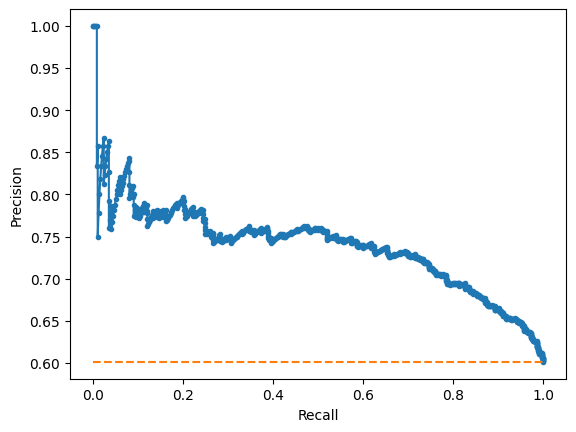

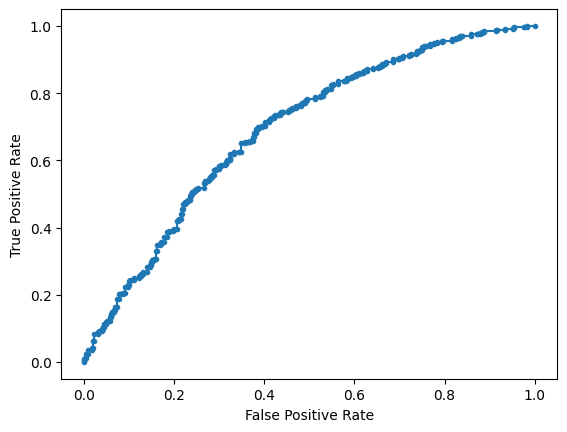

Accuracy: 66.97% Precision: 71.66% Recall: 74.52%
F1: 73.07% MCC: 0.3046
AUPRC: 73.95% AUROC: 69.07%
 accuracy [66.97142857142858]
 precision [71.66361974405851]
 recall [74.52471482889734]
 F1 [73.06616961789376]
 MCC [0.3045903577304289]
 AUPRC [73.94622410979707]
 AUROC [69.06588078921851]

Training # 2 3
2023-04-15 16:55:22.205054
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-15 16:55:22.419052
Discriminator is GMM
Means [-0.1430544063653172, -2.7919110373926976]
Variances [1.46920318 2.01096275]
Priors [0.56522606 0.43477394]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2074:1423 59.31%
Computed class weights: {0: 1.2287420941672522, 1: 0.8430568948891032}
Valid 1:0 533:341 60.98%
FIT
2023-04-15 16:55:23.539834


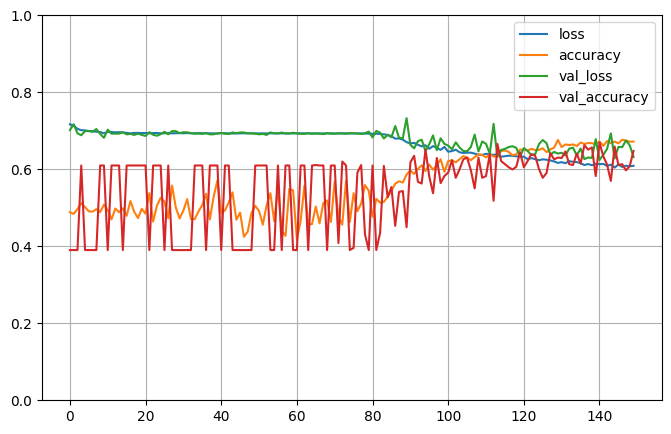


Testing # 2 3
2023-04-15 16:57:46.744297
2023-04-15 16:57:46.744338
PREDICT
2023-04-15 16:57:46.749666
Test 1:0 533:341 60.98%
Predict 1:0 575:299 65.79%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.5571193 mean 0.17167018 std
Range of scores: 0.04197845 to 0.86535233
Score threshold 0.5
Confusion matrix
 [[166 175]
 [133 400]]
Normalized matrix
 [[0.18993135 0.20022883]
 [0.15217391 0.4576659 ]]
Extreme scores correct, pos:neg 212 78
Extreme scores incorrect pos:neg 86 35


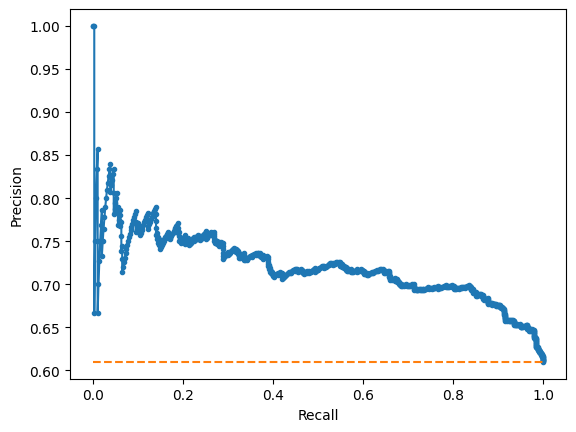

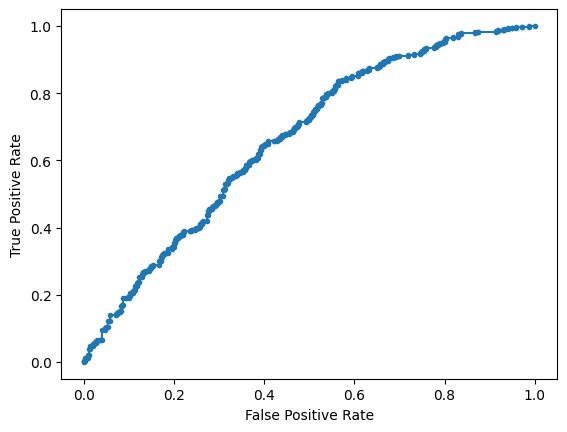

Accuracy: 64.76% Precision: 69.57% Recall: 75.05%
F1: 72.20% MCC: 0.2440
AUPRC: 72.04% AUROC: 66.21%
 accuracy [64.75972540045767]
 precision [69.56521739130434]
 recall [75.046904315197]
 F1 [72.20216606498195]
 MCC [0.24396009711289432]
 AUPRC [72.04284009752253]
 AUROC [66.2134875352814]

Training # 2 4
2023-04-15 16:57:47.349395
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-15 16:57:47.552082
Discriminator is GMM
Means [-2.7775134423966796, -0.10928572591265324]
Variances [2.08879181 1.51554389]
Priors [0.42693146 0.57306854]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2103:1395 60.12%
Computed class weights: {0: 1.253763440860215, 1: 0.8316690442225392}
Valid 1:0 506:367 57.96%
FIT
2023-04-15 16:57:48.681692


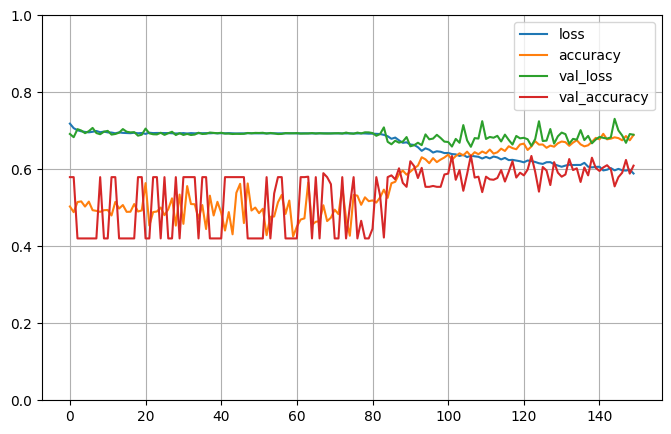


Testing # 2 4
2023-04-15 16:59:28.711246
2023-04-15 16:59:28.711654
PREDICT
2023-04-15 16:59:28.716875
Test 1:0 506:367 57.96%
Predict 1:0 451:422 51.66%
Test sizes (873, 1025) (873,)
Distrib of scores: 0.5126951 mean 0.21147503 std
Range of scores: 0.030582678 to 0.9459808
Score threshold 0.5
Confusion matrix
 [[224 143]
 [198 308]]
Normalized matrix
 [[0.25658648 0.16380298]
 [0.22680412 0.35280641]]
Extreme scores correct, pos:neg 181 127
Extreme scores incorrect pos:neg 71 88


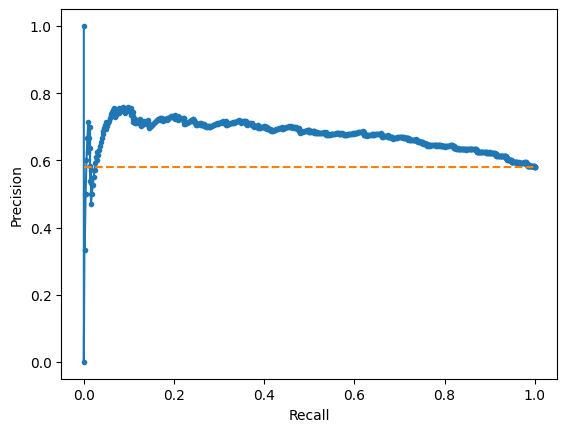

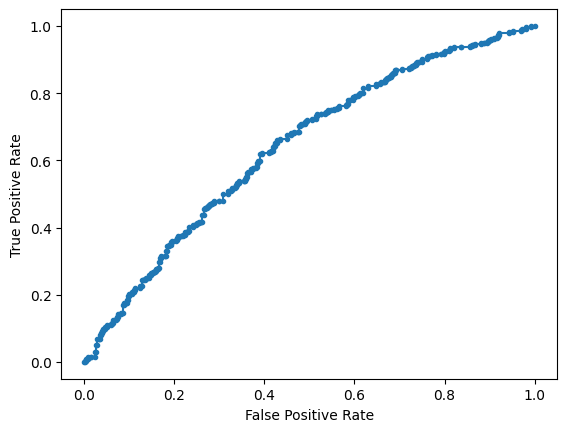

Accuracy: 60.94% Precision: 68.29% Recall: 60.87%
F1: 64.37% MCC: 0.2164
AUPRC: 67.48% AUROC: 63.90%
 accuracy [60.93928980526919]
 precision [68.29268292682927]
 recall [60.86956521739131]
 F1 [64.36781609195403]
 MCC [0.21637486255666197]
 AUPRC [67.48353833451928]
 AUROC [63.899150251478176]

Training # 2 5
2023-04-15 16:59:29.300668
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-15 16:59:29.499664
Discriminator is GMM
Means [-2.735796959325645, -0.12175395649636286]
Variances [1.99856448 1.47543451]
Priors [0.441858 0.558142]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2022:1475 57.82%
Computed class weights: {0: 1.1854237288135594, 1: 0.8647378832838774}
Valid 1:0 533:341 60.98%
FIT
2023-04-15 16:59:30.613449


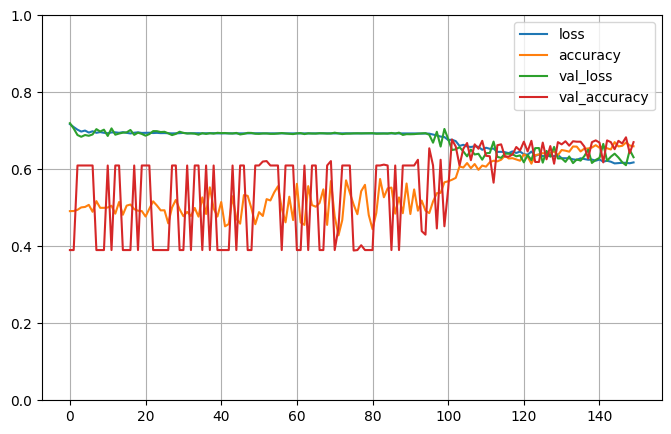


Testing # 2 5
2023-04-15 17:00:59.805142
2023-04-15 17:00:59.805243
PREDICT
2023-04-15 17:00:59.813264
Test 1:0 533:341 60.98%
Predict 1:0 495:379 56.64%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.5091536 mean 0.16359437 std
Range of scores: 0.03846823 to 0.80962527
Score threshold 0.5
Confusion matrix
 [[216 125]
 [163 370]]
Normalized matrix
 [[0.24713959 0.14302059]
 [0.18649886 0.42334096]]
Extreme scores correct, pos:neg 146 96
Extreme scores incorrect pos:neg 33 52


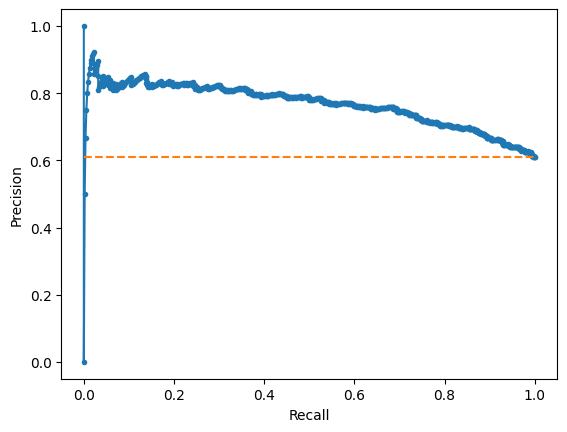

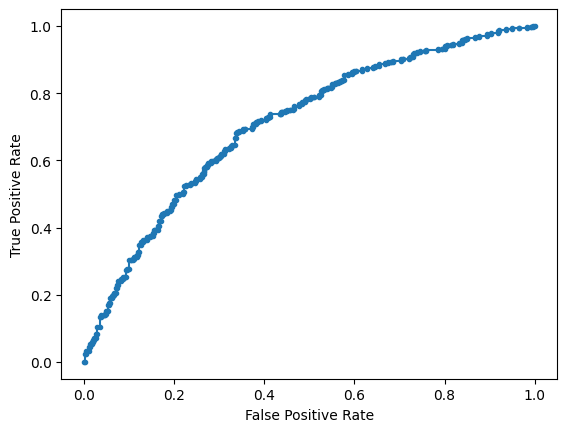

Accuracy: 67.05% Precision: 74.75% Recall: 69.42%
F1: 71.98% MCC: 0.3225
AUPRC: 76.59% AUROC: 70.77%
 accuracy [67.04805491990847]
 precision [74.74747474747475]
 recall [69.41838649155723]
 F1 [71.98443579766537]
 MCC [0.3224647902106097]
 AUPRC [76.59386557886654]
 AUROC [70.77022112427305]
2023-04-15 17:01:00.723556


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 63.04% std 2.88
 precision mean 69.95% std 2.82
 recall mean 66.88% std 8.52
 F1 mean 68.06% std 4.45
 MCC mean 0.2440 std 0.0443
 AUPRC mean 71.37% std 3.05
 AUROC mean 66.49% std 2.25
 accuracy [[64.91428571428571], [62.857142857142854], [58.924485125858126], [59.382151029748286], [61.741122565864835], [62.857142857142854], [66.97142857142858], [64.75972540045767], [60.93928980526919], [67.04805491990847]]
 precision [[70.22132796780684], [68.83629191321499], [68.45965770171149], [72.98701298701299], [70.2755905511811], [64.49511400651465], [71.66361974405851], [69.56521739130434], [68.29268292682927], [74.74747474747475]]
 recall [[68.7007874015748], [67.63565891472868], [54.90196078431373], [52.819548872180455], [66.11111111111111], [78.72763419483101], [74.52471482889734], [75.046904315197], [60.86956521739131], [69.41838649155723]]
 F1 [[69.45273631840797], [68.23069403714564], [60.93579978237214], [61.28680479825519], [68.12977099236642], [70.90420769919427], [73.